In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, OneCycleLR
from pytorch_lightning.callbacks import LearningRateMonitor


In [2]:
from fastai.vision.all import *

In [3]:
bs = 64
epochs = 5

In [4]:
def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageDataLoaders.from_folder(path, valid='val', 
                item_tfms=RandomResizedCrop(size, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats)))


In [5]:
dls = get_data(128, False, bs)

In [6]:
m = xresnet50(n_out=10)

In [7]:
class ConcatLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, scheduler1, scheduler2, total_steps, pct_start=0.5, last_epoch=-1):
        self.scheduler1 = scheduler1
        self.scheduler2 = scheduler2
        self.step_start = float(pct_start * total_steps) - 1
        super(ConcatLR, self).__init__(optimizer, last_epoch)
    
    def step(self):
        if self.last_epoch <= self.step_start:
            self.scheduler1.step()
        else:
            self.scheduler2.step()
        super().step()
        
    def get_lr(self):
        if self.last_epoch <= self.step_start:
            return self.scheduler1.get_lr()
        else:
            return self.scheduler2.get_lr()

In [8]:
sched_type = 'flat_and_anneal'
sched_type = 'one'

In [9]:
total_steps=len(dls[0])*epochs

In [17]:
class LModel(pl.LightningModule):
    def __init__(self, model, sched_type, total_steps):
        super(LModel, self).__init__()
        self.model = model
        self.sched_type = sched_type
        self.total_steps = total_steps
        self.loss_func = LabelSmoothingCrossEntropy()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        loss = self.loss_func(pred, y)
        return loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        pred = self(x)
        loss = self.loss_func(pred, y)
        acc = accuracy(pred, y)
        return {'val_loss': loss, 'acc': acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        self.result = {'avg_val_loss': avg_loss, 'avg_acc': avg_acc}
        print(self.result)
        return self.result
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4, betas=(0.9,0.99), eps=1e-06)
        if sched_type == 'flat_and_anneal':
            dummy = LambdaLR(optimizer, d)
            cosine = CosineAnnealingLR(optimizer, self.total_steps*0.5)
            scheduler = ConcatLR(optimizer, dummy, cosine, self.total_steps, 0.5)
        else:
            scheduler = OneCycleLR(optimizer, max_lr=3e-3, total_steps=self.total_steps, pct_start=0.3,
                                                            div_factor=10, cycle_momentum=True)        
        meta_sched = {
         'scheduler': scheduler,
         'interval': 'step',
         'frequency': 1
        }  
        return [optimizer], [meta_sched]

In [18]:
lmodel = LModel(m, sched_type, total_steps)
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=1, max_epochs=epochs, callbacks=[lr_monitor])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [19]:
trainer.fit(lmodel, dls[0], dls[1])


  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | XResNet                    | 23 M  
1 | loss_func | LabelSmoothingCrossEntropy | 0     


{'avg_val_loss': tensor(1.1113, device='cuda:0'), 'avg_acc': tensor(0.7344, device='cuda:0')}


{'avg_val_loss': tensor(1.3162, device='cuda:0'), 'avg_acc': tensor(0.6809, device='cuda:0')}


{'avg_val_loss': tensor(1.3942, device='cuda:0'), 'avg_acc': tensor(0.6338, device='cuda:0')}


{'avg_val_loss': tensor(1.1130, device='cuda:0'), 'avg_acc': tensor(0.7573, device='cuda:0')}


{'avg_val_loss': tensor(0.9764, device='cuda:0'), 'avg_acc': tensor(0.8178, device='cuda:0')}


{'avg_val_loss': tensor(0.9415, device='cuda:0'), 'avg_acc': tensor(0.8304, device='cuda:0')}



1

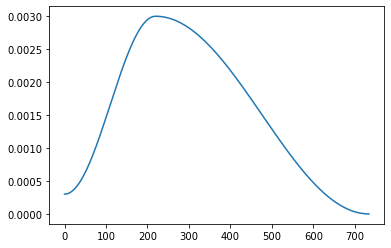

In [20]:
import matplotlib.pyplot as plt
plt.plot(lr_monitor.lrs['lr-Adam'])
plt.show()

In [21]:
lmodel.result['avg_acc']

tensor(0.8304, device='cuda:0')